# Agent mobility pattern

Agent movement throughout the area of interested is govern by `step_events`. In this example, we are going to learn about hwo we can define different mobility pattern and use probability density function to control agent's probability of visiting any place.

In [1]:
import simcronomicon as scon

import numpy as np
# For plotting
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

## Understanding Step Events

Step events are the building blocks of agent behavior in simcronomicon. They define:

- **When** agents perform activities (event sequence)
- **Where** agents go (place types and distances)  
- **How** agents choose destinations (probability functions)
- **What** agents do when they arrive (interaction functions)

### Event types explained

**SEND_HOME Events**
  - All agents return directly to their home addresses
  - No distance limitations or place type filtering
  - Used for: end-of-day, emergency evacuations, curfews

**DISPERSE Events**
  - Agents move to locations within specified constraints
  - Enables agent interactions at destinations
  - Used for: work, shopping, social activities

Here are some basic examples of the events:

In [2]:
# Simple end-of-day event (SEND_HOME)
# This event exists by default at the end of step_events list without your input.
sleep_event = scon.StepEvent(
    name="end_day",
    folk_action=scon.FolkSEIR.sleep
)

# Basic movement event (DISPERSE)
work_event = scon.StepEvent(
    name="work_commute",
    folk_action=scon.FolkSEIR.interact,
    event_type=scon.EventType.DISPERSE,
    max_distance=15000,  # 15km max travel
    place_types=['workplace']
)

**Important**

The simcronomicon framework automatically appends an "end_day" event to your step events sequence. This event:

- Calls the `sleep()` method for all agents
- Sends all agents back to their home addresses
- Resets agent energy for the next day
- Handles end-of-day status transitions

This means you should **NEVER** define your `step_events` like this:

In [3]:
# DON'T do this - the end_day event is added automatically!
step_events = [
    scon.StepEvent("work", scon.FolkSEIR.interact, ...),
    scon.StepEvent("shopping", scon.FolkSEIR.interact, ...),
    scon.StepEvent("end_day", scon.FolkSEIR.sleep)  # ← WRONG! The agents will go to sleep twice
]

Instead, do this:

In [4]:
# DO this - just define your activity events
step_events = [
    scon.StepEvent("work", scon.FolkSEIR.interact, ...),
    scon.StepEvent("shopping", scon.FolkSEIR.interact, ...)
    # End-of-day automatically added by the model
]

## Built-in movement patterns as a function of distances

Without any input of `probability_func` in `StepEvent` definition, an agent just choose any node with the corresponding place types to visit randomly without any regards of the distance, as long as they don't exceed the the given `max_distance`.

However, the real power of step events comes from probability functions that model realistic human mobility that can be dependent on distances and their other attributes.

There are 2 built-in proability functions in simcronomicon. Let's see how they look like and what they do.

1. **The log-normal mobility probability function** Log-normal PDF has been studied to model
    the human mobility pattern in this follow literature and its predecessor:
    Wang, W., & Osaragi, T. (2024). Lognormal distribution of daily travel time and a utility model for its emergence. Transportation Research Part A: Policy and Practice, 181, 104058. https://doi.org/10.1016/j.tra.2024.104058

    Some parameters that control this probability function are:
    - **median_distance**: The distance (in meters) where the distribution peaks - where agents are most likely to travel
      - 400m: Local/walking activities (corner store, nearby park)
      - 1100m: Neighborhood activities (local shopping, community center)
      - 3000m: City-wide activities (work commute, major shopping)
      - 8000m: Regional activities (weekend trips, specialized services)
  
    - **sigma**: Controls the **spread/variability** of travel preferences
      - Lower σ (0.6-0.8): Narrow distribution, consistent travel patterns
      - Higher σ (1.2-1.5): Wide distribution, highly variable travel patterns

    Below is the plot of this mobility function with a diverse set of parameters. You can play around with the parameter to simulate kind of travels!

In [10]:
fig = go.Figure()

distances = np.linspace(0, 10000, 100)  # 0.1 to 20km in meters

class DummyAgent:
    pass

dummy_agent = DummyAgent()

# Different parameter combinations using median_distance (more intuitive)
param_sets = [
    {'median_distance': 1100, 'sigma': 1.0, 'label': 'Neighborhood (1.1km median)', 'color': 'blue'},
    {'median_distance': 500, 'sigma': 0.8, 'label': 'Local (500m median)', 'color': 'red'},
    {'median_distance': 3000, 'sigma': 1.2, 'label': 'City-wide (3km median)', 'color': 'green'},
    {'median_distance': 8000, 'sigma': 0.6, 'label': 'Regional (8km median)', 'color': 'orange'},
    {'median_distance': 500, 'sigma': 1.5, 'label': 'Local but variable (500m, wide spread)', 'color': 'purple'}
]

for params in param_sets:
    probs = scon.log_normal_mobility(distances, dummy_agent, 
                                   median_distance=params['median_distance'], 
                                   sigma=params['sigma'])
    
    fig.add_trace(go.Scatter(
        x=distances/1000,
        y=probs,
        mode='lines',
        name=params['label'],
        line=dict(width=3, color=params['color']),
        hovertemplate=f'Median: {params["median_distance"]}m<br>' +
                     'Distance: %{x:.1f} km<br>Probability: %{y:.6f}<extra></extra>'
    ))

fig.update_layout(
    title='Log-Normal Mobility Functions: Different Activity Types<br><sub>Using intuitive median_distance parameter</sub>',
    xaxis_title='Distance (km)',
    yaxis_title='Probability Density',
    hovermode='x unified',
    width=900,
    height=600
)

fig.show()

Let's also see what happens when we adjust sigma...

In [11]:
fig_sigma = go.Figure()

# Keep median distance constant, vary sigma
sigma_scenarios = [
    {'sigma': 0.5, 'label': 'σ=0.5 (Narrow, consistent)', 'color': 'red'},
    {'sigma': 1.0, 'label': 'σ=1.0 (Default)', 'color': 'blue'},
    {'sigma': 1.5, 'label': 'σ=1.5 (Wide, variable)', 'color': 'green'},
    {'sigma': 2.0, 'label': 'σ=2.0 (Very wide)', 'color': 'orange'}
]

median_dist = 2000  # 2km median for all scenarios

for scenario in sigma_scenarios:
    probs = scon.log_normal_mobility(distances, dummy_agent, 
                                   median_distance=median_dist, 
                                   sigma=scenario['sigma'])
    
    fig_sigma.add_trace(go.Scatter(
        x=distances/1000,
        y=probs,
        mode='lines',
        name=scenario['label'],
        line=dict(width=3, color=scenario['color']),
        hovertemplate=f'σ={scenario["sigma"]}<br>' +
                     'Distance: %{x:.1f} km<br>Probability: %{y:.6f}<extra></extra>'
    ))

fig_sigma.update_layout(
    title='Log-Normal Mobility: Effect of Sigma Parameter<br><sub>Same median distance (2km) with different spread values</sub>',
    xaxis_title='Distance (km)',
    yaxis_title='Probability Density',
    hovermode='x unified',
    width=900,
    height=500
)

fig_sigma.show()

2. **The energy exponential mobility probability function** - This function models agent movement based on their current energy levels, making it particularly well-suited for **short-range social and leisure activities**.

    Unlike log-normal mobility which models general travel patterns, energy exponential mobility captures the reality that **agent fatigue directly affects their willingness to travel**. This makes it perfect for modeling:
    - **After-work social activities**: Tired agents prefer nearby restaurants, cafes, or parks
    - **Evening leisure**: Low-energy agents choose local entertainment over distant venues
    - **Weekend relaxation**: Energy levels determine whether agents visit neighborhood spots or travel across town
    - **Daily social interactions**: Coffee meetings, casual visits, and spontaneous gatherings

    **Parameter Control**
    - **distance_scale**: Controls how quickly probability decays with distance (default: 10)
      - Lower values (50-200): Very local behavior, suitable for neighborhood interactions
      - Higher values (2000-5000): Wider travel range, suitable for shopping or distance leisure activities
    - **Agent energy**: Dynamically affects willingness to travel during simulation. The lower the agent energy is, the higher the decay rate of the probability function will be.


In [7]:
fig_energy_default = go.Figure()

distances_km = np.linspace(0, 4, 10)  # 0.1 to 3 km
distances_m = distances_km * 1000  # Convert to meters for function

class DummyAgentWithEnergy:
    def __init__(self, energy, max_energy=10):
        self.energy = energy
        self.max_energy = max_energy

energy_scenarios = [
    {'energy': 10, 'max_energy': 10, 'label': 'High Energy (10/10)', 'color': 'green'},
    {'energy': 7, 'max_energy': 10, 'label': 'Good Energy (7/10)', 'color': 'blue'},
    {'energy': 4, 'max_energy': 10, 'label': 'Medium Energy (4/10)', 'color': 'orange'},
    {'energy': 2, 'max_energy': 10, 'label': 'Low Energy (2/10)', 'color': 'red'},
]

for scenario in energy_scenarios:
    agent = DummyAgentWithEnergy(scenario['energy'], scenario['max_energy'])
    probs = scon.energy_exponential_mobility(distances_m, agent)  # Using default distance_scale=1000
    
    fig_energy_default.add_trace(go.Scatter(
        x=distances_km,
        y=probs,
        mode='lines',
        name=scenario['label'],
        line=dict(width=3, color=scenario['color']),
        hovertemplate=f'Energy: {scenario["energy"]}/{scenario["max_energy"]}<br>' +
                     'Distance: %{x:.2f} km<br>Probability: %{y:.6f}<extra></extra>'
    ))

fig_energy_default.update_layout(
    title='Energy Exponential Mobility: Different Energy Levels<br><sub>Default distance_scale=1000 (moderate decay)</sub>',
    xaxis_title='Distance (km)',
    yaxis_title='Probability Density',
    hovermode='x unified',
    width=900,
    height=500
)

fig_energy_default.show()

## Creating your own custom mobility functions

While simcronomicon provides two powerful built-in mobility functions (log-normal and energy exponential), you might want to create your own custom probability functions to model specific behaviors or test different mobility hypotheses.

### Function Requirements

Your custom probability function must follow these rules:

1. **Accept exactly 2 arguments**: `(distances, agent)`
2. **Return probabilities**: Values between 0 and 1
3. **Normalize probabilities**: They should sum to 1 for proper selection
4. **Handle numpy arrays**: Work with array inputs for distances
5. **Be robust**: Handle edge cases (empty arrays, zero distances)

### Basic Template

In [7]:
def your_custom_mobility(distances, agent):
    """
    Template for custom mobility probability function.
    
    Parameters
    ----------
    distances : array-like
        Distances to potential destinations in meters
    agent : object
        The agent object (can access agent.energy, agent.status, etc.)
        
    Returns
    -------
    numpy.ndarray
        Normalized probabilities (sum to 1)
    """
    import numpy as np
    distances = np.array(distances)
    
    # Your custom logic here
    probs = np.ones_like(distances)  # Replace with your formula
    
    # Always normalize! Or else numpy will give you an error!
    return probs / probs.sum() if probs.sum() > 0 else np.ones_like(probs) / len(probs)

Example 1: Distance Preference Function

In [8]:
def distance_preference_mobility(distances, agent, preference="nearby"): 
    import numpy as np
    distances = np.array(distances)

    if preference == "nearby":
        # Exponential decay - prefer closer locations
        probs = np.exp(-distances / 2000)  # 2km characteristic distance
    elif preference == "far":
        # Linear increase - prefer farther locations
        probs = distances / np.max(distances) if np.max(distances) > 0 else np.ones_like(distances)
    else:  # uniform
        # All distances equally likely
        probs = np.ones_like(distances)

    # Normalize to sum to 1
    return probs / probs.sum() if probs.sum() > 0 else np.ones_like(probs) / len(probs)

Example 2: Status-Based Mobility (for SEIR models)

In [9]:
def status_based_mobility(distances, agent): 
    import numpy as np 
    distances = np.array(distances)

    # Default mobility pattern
    characteristic_distance = 3000  # 3km default

    # Adjust based on agent status
    if hasattr(agent, 'status'):
        if agent.status == 'I':  # Infectious - stay closer to home
            characteristic_distance = 1000  # 1km
        elif agent.status == 'R':  # Recovered - normal mobility
            characteristic_distance = 3000  # 3km
        elif agent.status == 'S':  # Susceptible - slightly more adventurous
            characteristic_distance = 4000  # 4km
        # E (Exposed) uses default

    # Exponential decay with status-dependent characteristic distance
    probs = np.exp(-distances / characteristic_distance)

    return probs / probs.sum()

Since the mobility function takes in as well the agent as an input, you can actually custom it to be dependent on any agent attributes that exist in your model!

## Example of how you can use it!

Here, we provide you a short example of how to define `step_events` and use it in a simulation. We are going to use `greet_neighbors` to define an event of small interaction around the neighborhood at the beginning of the day using the built-in `energy_exponential_mobility` and `chore` to define activities of going to work, doing some shopping, or some longer range travelling with a purpose in mind, using the custom `distance_preference_mobility`.

In [10]:
folk_class = scon.FolkSEIR

step_events = [
        scon.StepEvent("greet_neighbors", folk_class.interact, scon.EventType.DISPERSE, 150, [
                       'accommodation'], scon.energy_exponential_mobility),
        scon.StepEvent("chore", folk_class.interact, scon.EventType.DISPERSE, 20000,
               ['commercial', 'workplace', 'education', 'religious'], 
               lambda distances, agent: distance_preference_mobility(distances, agent, "far"))
    ]

Then we define the town, the model, and run the simulation as before.

In [11]:
model_params = scon.SEIRModelParameters(
    max_energy=5, beta=0.4, sigma=6, gamma=5, xi=200)
model = scon.SEIRModel(model_params, step_events)

# We are loading the town from the test data here so you don't have to generate any new town for this tutorial!
town_graph_path = "../test/test_data/aachen_dom_500m.graphmlz"
town_params = scon.TownParameters(1000, 10)
town = scon.Town.from_files(town_graph_path=town_graph_path, 
                            config_path= "../test/test_data/aachen_dom_500m_config.json", town_params=town_params)

sim = scon.Simulation(town, model, 100)
sim.run()

[1/3] Decompressing the graphmlz file...
[2/3] Load the metadata...
[3/3] Rebuild the town object...
Town graph successfully built from input files!
Step has been run 1
Status: {'S': 986, 'E': 4, 'I': 10, 'R': 0}
Step has been run 2
Status: {'S': 979, 'E': 11, 'I': 10, 'R': 0}
Step has been run 3
Status: {'S': 972, 'E': 18, 'I': 10, 'R': 0}
Step has been run 4
Status: {'S': 964, 'E': 26, 'I': 10, 'R': 0}
Step has been run 5
Status: {'S': 958, 'E': 32, 'I': 0, 'R': 10}
Step has been run 6
Status: {'S': 958, 'E': 28, 'I': 4, 'R': 10}
Step has been run 7
Status: {'S': 955, 'E': 24, 'I': 11, 'R': 10}
Step has been run 8
Status: {'S': 952, 'E': 20, 'I': 18, 'R': 10}
Step has been run 9
Status: {'S': 945, 'E': 19, 'I': 26, 'R': 10}
Step has been run 10
Status: {'S': 931, 'E': 27, 'I': 32, 'R': 10}
Step has been run 11
Status: {'S': 919, 'E': 39, 'I': 28, 'R': 14}
Step has been run 12
Status: {'S': 907, 'E': 48, 'I': 24, 'R': 21}
Step has been run 13
Status: {'S': 898, 'E': 54, 'I': 20, 'R': 

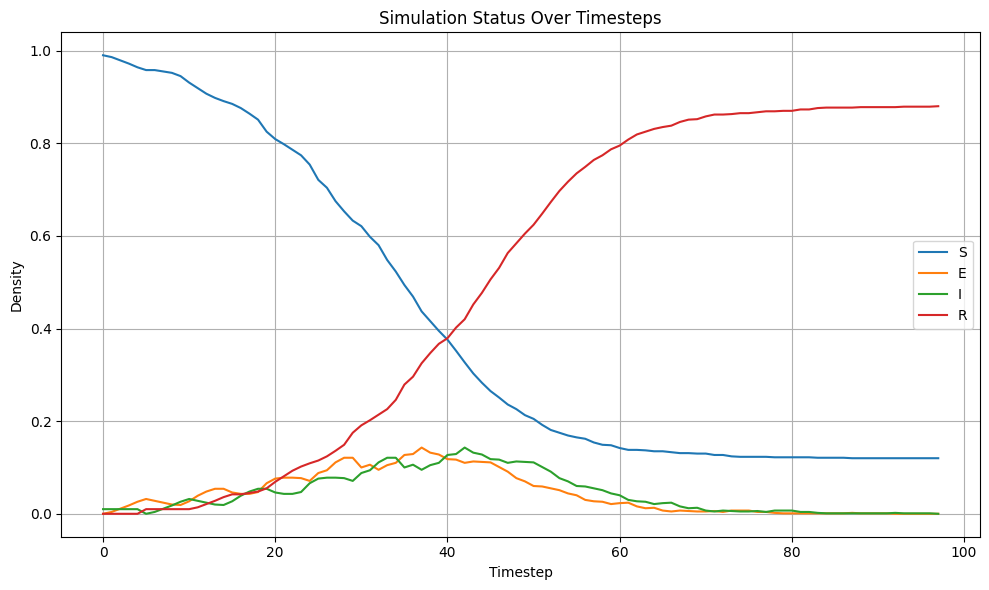

In [12]:
scon.plot_status_summary_from_hdf5("simulation_output.h5")

In [13]:
scon.visualize_folks_on_map_from_sim("simulation_output.h5", town_graph_path)

KeyboardInterrupt: 

**Have fun playing around with how your agents move!** 

However, there is still 1 more important feature regarding the way agents move, which is `priority_place` mechanism. This feature is dormant for simple model like SEIR and SEIsIrR model, but with **SEIQRDV Model** where vaccination and hospital vaccination capacity are a topic of concern, we have to simulate movement in a slightly more complex manner. Check out the documentation `Advanced Simulation Features: SEIQRDV Model` to understand how `simcronomicon` makes it happen and our jupyternotebook tutorial to see the model in action~